# Load data

In [14]:
import pandas as pd

df_dataset = pd.read_csv("preprocessed_dataset.csv",index_col=0).drop(columns=["1d_pct_price_var","5d_pct_price_var"])

# Train - test separation and target variable discretization

In [15]:
import plotly.express as px

fig = px.histogram(df_dataset, x="10d_pct_price_var", nbins=50)
fig.update_layout(
    title="Distribution of 10-Days % Price Variation",
    xaxis_title="10d_pct_price_var",
    yaxis_title="Count",
    bargap=0.1
)
fig.show()


In [16]:
def var_class(x, alpha=0.01):
    if x < - alpha:
        return 0
    elif x > alpha:
        return 1
    else:
        return 2
df_dataset["target"] = df_dataset["10d_pct_price_var"].apply(var_class)

df_dataset.target.value_counts()

target
1    1567
0    1340
2     391
Name: count, dtype: int64

In [17]:
df_train = df_dataset.iloc[:-900]
df_test = df_dataset.iloc[-900:]

x_train = df_train.drop(columns=["target","10d_pct_price_var","observation_date"])
y_train = df_train["target"]
x_test = df_test.drop(columns=["target","10d_pct_price_var","observation_date"])
y_test = df_test["target"]

# Model Hyperparameters Selection

In [ ]:
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from sklearn.metrics import make_scorer, accuracy_score

sign_accuracy = make_scorer(accuracy_score)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "num_leaves": trial.suggest_int("num_leaves", 10, 50, step=5),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
        "objective": "multiclass",
        "num_class": 3,
        "random_state": 0,
        "device": "gpu",  
        "verbose": -1
    }

    model = LGBMClassifier(**params)

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=sign_accuracy, n_jobs=-1)

    return np.mean(scores)


# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\nLGBM Optuna Results")
print("Best Sign Accuracy score (CV):", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-07-05 16:12:17,048] A new study created in memory with name: no-name-4dbcdec5-071d-4bc3-8409-5f23058b290b


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-07-05 16:13:53,548] Trial 0 finished with value: 0.6100772120200334 and parameters: {'n_estimators': 150, 'max_depth': 11, 'num_leaves': 45, 'learning_rate': 0.058583102931344236, 'feature_fraction': 0.5110248747513506, 'bagging_fraction': 0.5273307967759346, 'bagging_freq': 5, 'min_child_samples': 61, 'lambda_l2': 5.4118137881881445}. Best is trial 0 with value: 0.6100772120200334.
[I 2025-07-05 16:15:29,979] Trial 1 finished with value: 0.6363508625486922 and parameters: {'n_estimators': 100, 'max_depth': 9, 'num_leaves': 45, 'learning_rate': 0.09403315883814424, 'feature_fraction': 0.5067117822231982, 'bagging_fraction': 0.5808980393912515, 'bagging_freq': 2, 'min_child_samples': 34, 'lambda_l2': 0.6492331171749244}. Best is trial 1 with value: 0.6363508625486922.


In [ ]:
from lightgbm import LGBMClassifier

params =  {'n_estimators': 450, 
           'max_depth': 8, 
           'num_leaves': 45, 
           'learning_rate': 0.019576568177450394, 
           'feature_fraction': 0.6532239598289056, 
           'bagging_fraction': 0.9896076320668561, 
           'bagging_freq': 3, 
           'min_child_samples': 19, 
           'lambda_l2': 2.8317885229881714,
           'device':'gpu',
           'verbose': -1,
           'random_state': 0
           }
# lgbm_reg = LGBMClassifier(**study.best_params, device="gpu", verbose=-1, random_state=0)
lgbm_class = LGBMClassifier(**params)
lgbm_class.fit(x_train,y_train)

LGBMClassifier(bagging_fraction=0.9896076320668561, bagging_freq=3,
               device='gpu', feature_fraction=0.6532239598289056,
               lambda_l2=2.8317885229881714, learning_rate=0.019576568177450394,
               max_depth=8, min_child_samples=19, n_estimators=450,
               num_leaves=45, random_state=0, verbose=-1)

In [ ]:
import numpy as np

def sign_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

train_preds = lgbm_class.predict(x_train)
test_preds = lgbm_class.predict(x_test)


train_sign_accuracy = sign_accuracy(y_train,train_preds)
test_sign_accuracy = sign_accuracy(y_test,test_preds)

print("Train dataset performance: ",train_sign_accuracy)
print("Test dataset performance: ",test_sign_accuracy)

Train dataset performance:  1.0
Test dataset performance:  0.47


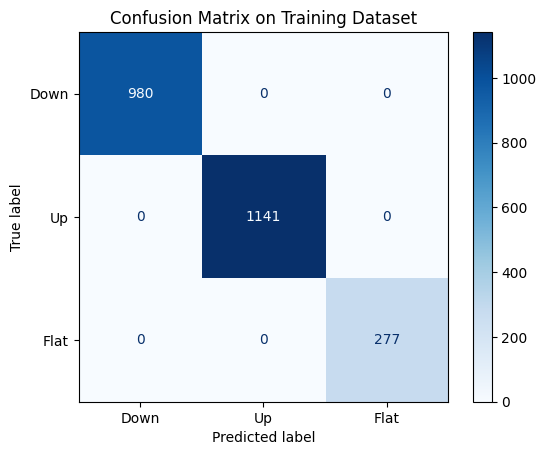

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Down","Up","Flat"],
        cmap=plt.cm.Blues
    )

    t = confusion_matrix(y_true, y_pred).ravel()

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset")

displayConfusionMatrix(y_train, train_preds, "Training")

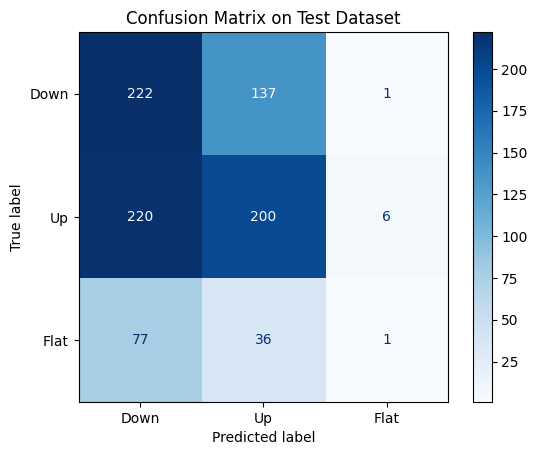

In [ ]:
displayConfusionMatrix(y_test, test_preds, "Test")